# Image processing coursework 1

## Loading in images and dependencies

(2814, 2110, 3)
(2814, 2110, 3)


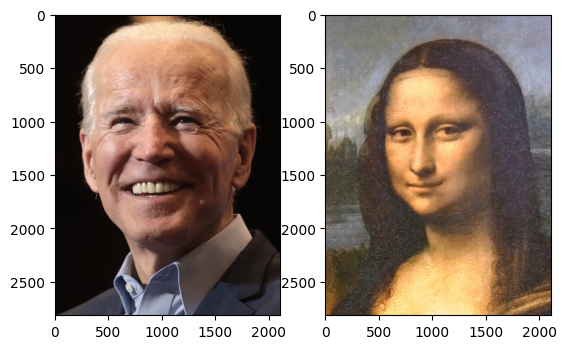

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Delaunay
import cv2
import os

image1 = plt.imread('Images/Joe_Biden.jpg')
image2 = plt.imread('Images/MonaLisa.jpg')
# image2 = np.copy(image2[0:2814, 100:2210,:]) # sunak
image2 = np.copy(image2[100:2914, 900:3010,:]) # MonaLisa
print(image1.shape)
print(image2.shape)
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)

## Detecting facial landmarks

In [2]:
def shape_to_np(shape, dtype="int"):
    '''
    convert the dlib shape to numpy ndarray
    '''
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(68):
        coords[i,0] = shape.part(i).x
        coords[i,1] = shape.part(i).y
    return coords

def landmark_detector(img):
    '''
    Outputs ndarray of landmarks for img
    '''
    import dlib
    # get the landmark detector
    print("importing model")
    dat_path = 'shape_predictor_68_face_landmarks.dat'
    file_path = 'shape_predictor_68_face_landmarks.dat.bz2'
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    
    if not os.path.exists(dat_path):
        print("downloading model")
        os.system('wget {} -O {}'.format(url, file_path))
        os.system('bunzip2 {} '.format(file_path))
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    rects = detector(img, 1)
    rect = rects[0]
    shape = predictor(img, rect)
    shape = shape_to_np(shape)
    return shape

def add_edge_marks(img, landmarks, size=(6, 7)):
    '''
    NOTE: size should be (W, H)
    Add the edge landmarks to the img
    '''
    H, W, _ = img.shape
    H -= 1
    W -= 1
    # side made of (constant axis value, moving axis lim, moving axis)
    # reverse 0 and 1 as plt scatter is x, y (W, H)
    sides = [(0, W, 0), (H, W, 0), (0, H, 1), (W, H, 1)]
    for (ca, mal, ma) in sides:
        ma_range = np.linspace(0, mal, size[ma], dtype=int)
        edge = np.full((size[ma], 2),ca,dtype=int)
        edge[:,ma] = ma_range
        landmarks = np.vstack((landmarks, edge))
    return landmarks

### Storing/Loading the landmarks

In [3]:
landmark1, landmark2 = 0, 0
if os.path.exists('landmark1.csv'):
    # landmarks should be stored as csv files already
    landmark1 = np.loadtxt('landmark1.csv', delimiter=',', dtype=int)
    landmark2 = np.loadtxt('landmark2.csv', delimiter=',', dtype=int)
else:
    landmark = landmark_detector(image1)
    landmark1 = add_edge_marks(image1, landmark)
    landmark = landmark_detector(image2)
    landmark2 = add_edge_marks(image2, landmark)

    np.savetxt('landmark1.csv', landmark1, delimiter=',')
    np.savetxt('landmark2.csv', landmark2, delimiter=',')

C:\Users\wangz\AppData\Local\Temp\ipykernel_9068\3795352047.py:4: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  landmark1 = np.loadtxt('landmark1.csv', delimiter=',', dtype=int)
C:\Users\wangz\AppData\Local\Temp\ipykernel_9068\3795352047.py:5: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` pars

Showing the landmarks

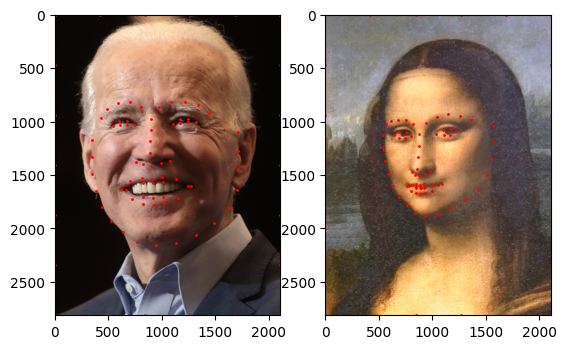

In [4]:
plt.subplot(1, 2, 1)
plt.scatter(landmark1[:, 0], landmark1[:,1], s=1, color='red')
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.scatter(landmark2[:, 0], landmark2[:,1], s=1, color='red')
plt.imshow(image2)

## Constructing triangles

Functions for determining points in triangle

In [5]:
def barycentric(p, p1, p2):
    '''
    Support an array of points 2D
    '''
    return np.sign((p[:,0] - p2[0]) * (p1[1] - p2[1]) - (p1[0] - p2[0]) * (p[:,1] - p2[1]))

def in_triangle(points, tri_coord):
    '''
    Support an array of points
    '''
    # d1, d2, d3 = all the points' area sign with edge 1, 2, 3 
    d1 = barycentric(points, tri_coord[0], tri_coord[1])
    d2 = barycentric(points, tri_coord[1], tri_coord[2])
    d3 = barycentric(points, tri_coord[2], tri_coord[0])

    return np.where((d1==d2)&(d2==d3))

def segmented_image_cv(img_dim, tri_coords):
    import cv2
    H, W = img_dim
    output = np.zeros((H, W))
    n_tri = tri_coords.shape[0]
    for k in range(n_tri):
        cv2.fillConvexPoly(output, tri_coords[k], k)
    return output

def segmented_image(img_dim, tri_coords):
    H, W = img_dim
    output = np.zeros((H, W))
    output = output.flatten()
    y, x = np.mgrid[0:H, 0:W]
    all_positions = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    n_tri = tri_coords.shape[0]
    for k in range(n_tri):
        points_in_k = in_triangle(all_positions, tri_coords[k])
        output[points_in_k] = k
    output = output.reshape((H, W))
    return output

Only need the triangulation of one set of landmarks and take the indices. This is because the landmarks have an order corresponding to each other.

In [6]:
tri1 = Delaunay(landmark1)

simplices1 = tri1.simplices
points1_tri = landmark1[simplices1]
simplices2 = tri1.simplices
points2_tri = landmark2[simplices2]

Showing the triangles

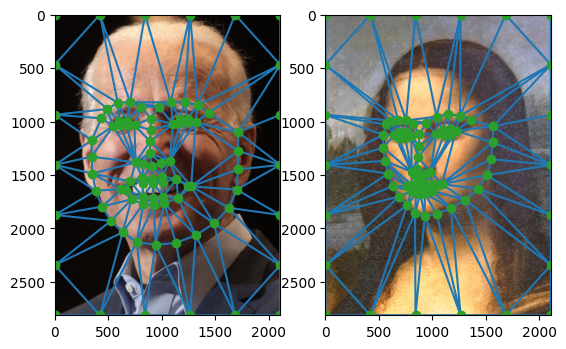

In [7]:
plt.subplot(1, 2, 1)
plt.triplot(landmark1[:,0], landmark1[:,1], simplices1)
plt.imshow(image1)
plt.plot(landmark1[:,0], landmark1[:,1], 'o')
plt.subplot(1, 2, 2)
plt.triplot(landmark2[:,0], landmark2[:,1], simplices2)
plt.imshow(image2)
plt.plot(landmark2[:,0], landmark2[:,1], 'o')
plt.show()

Determining which point is in which triangle, visualizing it to make sure the order are the same. Also useful for later.

In [8]:
seg1 = segmented_image_cv(image1.shape[:-1], points1_tri)
seg2 = segmented_image_cv(image2.shape[:-1], points2_tri)

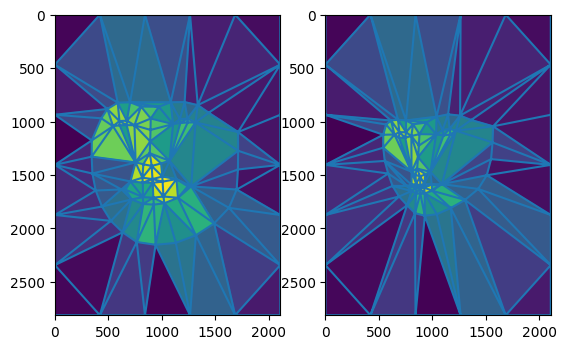

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(seg1)
plt.triplot(landmark1[:,0], landmark1[:,1], simplices1)

plt.subplot(1, 2, 2)
plt.imshow(seg2)
plt.triplot(landmark2[:,0], landmark2[:,1], simplices2)
plt.show()

## Create the intermediate image triangles

In [10]:
n_frames = 50
ratio = np.linspace(0, 1, n_frames)
triangles = [] # [I1, I2, I3, ... I10] of triangles
for i in range(n_frames):
    new_coords = (1-ratio[i])*points1_tri + ratio[i]*points2_tri
    triangles.append(new_coords.astype(np.int32))

## Estimating affine warp

In [11]:
def getAffineWarp(prev, next):
    """
    Should be shape: [[x1, y1], [x2, y2], [x3, y3]] (3x2)
    !!! horizontal coord then vertical
    """
    length = prev.shape[0]
    prev = np.hstack((prev, np.ones((length, 1))))
    next = np.hstack((next, np.ones((length, 1))))
    W = np.linalg.pinv(prev) @ next
    return np.round(W, 4)

## Mapping all the points in triangles

In [12]:
def bi_lerp(image, x, y):
    """
    !!! order x, y
    x: 1D, y: 1D
    """
    H, W = image.shape[:2]

    x = np.clip(x, 0, W - 1.01)
    y = np.clip(y, 0, H - 1.01)
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)

    dx = x - x0
    dy = y - y0

    w00 = (1 - dx) * (1 - dy)
    w01 = dx * (1 - dy)
    w10 = (1 - dx) * dy
    w11 = dx * dy

    interpolated_values = (
        w00[:, np.newaxis] * image[y0, x0] +
        w01[:, np.newaxis] * image[y0, x0 + 1] +
        w10[:, np.newaxis] * image[y0 + 1, x0] +
        w11[:, np.newaxis] * image[y0 + 1, x0 + 1]
    )
    return interpolated_values



def get_warp(im, start_tri, this_tri):
    H, W, = im.shape[:2]
    this_frame = np.zeros_like(im)
    for k in range(start_tri.shape[0]):
        
        warpTo = getAffineWarp(np.float32(start_tri[k]), np.float32(this_tri[k]))
        Inv_warp_from_start = np.linalg.pinv(warpTo)
        
        empty = np.zeros((H, W))
        cv2.fillConvexPoly(empty, this_tri[k], 1)
        coords_in_tri_yx = np.column_stack(np.nonzero(empty))
        # Since affine is fitted (x, y) nonzero returns (y,x)
        coords_in_tri_xy = coords_in_tri_yx[:, [1, 0]]
        coords_with_bias= np.hstack((coords_in_tri_xy, np.ones((coords_in_tri_xy.shape[0], 1)))).astype(int) # bias terms
        start_pos = coords_with_bias @ Inv_warp_from_start
        start_pos = start_pos[:, :-1].T / start_pos[:,-1]
        # lower_bounds = np.array([0, 0])
        # upper_bounds = np.array([H-1, W-1])
        # start_pos = np.clip(start_pos.T, lower_bounds, upper_bounds)
        start_pos = start_pos.T.astype(int)
        # start pos is x, y
        this_frame[coords_in_tri_yx[:, 0], coords_in_tri_yx[:,1]] = bi_lerp(im, start_pos[:,0], start_pos[:,1])

    return this_frame

## Performing the warp and color blend 
Takes around 15 seconds for each frame for warping images with size 2814x2110x3.

There are 50 frames in total including the start and end images, so estimates frame 2-49.

In [13]:
Images = [image1]
for i in range(1, n_frames-1):
    print("Estimating frame: ", i+1)
    im1 = get_warp(image1, triangles[0], triangles[i])
    im2 = get_warp(image2, triangles[-1], triangles[i])
    im = (1-i/n_frames)*im1 + (i/n_frames)*im2
    Images.append(np.int32(im))

Images.append(image2)

Estimating frame:  2
Estimating frame:  3
Estimating frame:  4
Estimating frame:  5
Estimating frame:  6
Estimating frame:  7
Estimating frame:  8
Estimating frame:  9
Estimating frame:  10
Estimating frame:  11
Estimating frame:  12
Estimating frame:  13
Estimating frame:  14
Estimating frame:  15
Estimating frame:  16
Estimating frame:  17
Estimating frame:  18
Estimating frame:  19
Estimating frame:  20
Estimating frame:  21
Estimating frame:  22
Estimating frame:  23
Estimating frame:  24
Estimating frame:  25
Estimating frame:  26
Estimating frame:  27
Estimating frame:  28
Estimating frame:  29
Estimating frame:  30
Estimating frame:  31
Estimating frame:  32
Estimating frame:  33
Estimating frame:  34
Estimating frame:  35
Estimating frame:  36
Estimating frame:  37
Estimating frame:  38
Estimating frame:  39
Estimating frame:  40
Estimating frame:  41
Estimating frame:  42
Estimating frame:  43
Estimating frame:  44
Estimating frame:  45
Estimating frame:  46
Estimating frame: 

## Producing a video (requires imageio package)
The output is computed and stored in a mp4 file in the same folder. There is no need to run this block without a package

In [14]:
import imageio
output_path = 'face_video.mp4'
with imageio.get_writer(output_path, mode='I', fps=30) as writer:
    for k in range(len(Images)):
        writer.append_data(Images[k].astype(np.uint8))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2110, 2814) to (2112, 2816) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Showing the output, should work without addtional packages in a notebook environment.

In [15]:
from IPython.display import Video
Video(output_path)